<a href="https://colab.research.google.com/github/SerDavidE/Eniac-Discount-Analysis/blob/main/Eniac_Product_Discount_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
import pandas as pd
from datetime import datetime
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt

# Data

In [ ]:
#selecting the data from my google drive
brands = "/content/drive/MyDrive/Eniac_Files/Original Files/brands.csv"
order_lines = "/content/drive/MyDrive/Eniac_Files/Original Files/orderlines.csv"
orders = "/content/drive/MyDrive/Eniac_Files/Original Files/orders.csv"
products = "/content/drive/MyDrive/Eniac_Files/Original Files/products.csv"
products_with_categories = "/content/drive/MyDrive/Eniac_Files/product_cl.csv"
brands_df = pd.read_csv(brands)
orderlines_df = pd.read_csv(order_lines)
orders_df = pd.read_csv(orders)
products_df = pd.read_csv(products)
products_df2 = pd.read_csv(products_with_categories, sep=";")

In [ ]:
brands_cl = brands_df.copy()
orderlines_cl = orderlines_df.copy()
orders_cl = orders_df.copy()
products_cl = products_df.copy()

# Data Cleaning

## Orders Table


In [ ]:
#the changes
orders_cl["created_date"] = pd.to_datetime(orders_cl["created_date"])
orders_cl = orders_cl.loc[~orders_cl.total_paid.isna(), :]

## Order_lines Table

In [ ]:
#the changes
orderlines_cl = orderlines_cl.rename(columns={"id_order":"order_id"})
orderlines_cl["date"] = pd.to_datetime(orderlines_cl["date"])
two_dot_percentage = ((orderlines_cl.unit_price.str.contains("\d+\.\d+\.\d+").value_counts()[1] / orderlines_cl.shape[0])*100).round(2)
print(f"The 2 dot problem represents {two_dot_percentage}% of the rows in our DataFrame")
two_dot_order_ids_list = orderlines_cl.loc[orderlines_cl.unit_price.str.contains("\d+\.\d+\.\d+"), "order_id"]
orderlines_cl = orderlines_cl.loc[~orderlines_cl.order_id.isin(two_dot_order_ids_list)]
orderlines_cl["unit_price"] = pd.to_numeric(orderlines_cl["unit_price"])

The 2 dot problem represents 12.3% of the rows in our DataFrame


<ipython-input-6-8f74790894ae>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orderlines_cl["unit_price"] = pd.to_numeric(orderlines_cl["unit_price"])


## Products Tables

In [ ]:
#the changes
products_cl = products_cl.drop_duplicates()
products_cl.loc[products_cl["desc"].isna(), "desc"] = products_cl.loc[products_cl["desc"].isna(), "name"]
products_cl = products_cl.loc[~products_cl["price"].isna()]
products_cl = products_cl.loc[(~products_cl.price.astype(str).str.contains("\d+\.\d+\.\d+")) & (~products_cl.price.astype(str).str.contains("\d+\.\d{3,}")), :]
products_cl["price"] = pd.to_numeric(products_cl["price"])

# Data Quality


## 1.  Define Pandas display format

In [ ]:
pd.set_option("display.float_format", lambda x: "%.2f" % x)

## 2. Exclude unwanted orders

In [ ]:
# Include only actual purchases
mask = orders_cl['state'].isin(['Cancelled', 'Pending', 'Shopping Basket', 'Place Order'])
orders_cl.drop(orders_cl[mask].index[:], inplace=True)

# Let's create a copy of the orders_cl DataFrame, to make sure any of our changes won't affect the original DataFrame.
actual_purchases_df = orders_cl.copy()
actual_purchases_df = actual_purchases_df.loc[actual_purchases_df['state'].isin(["Completed"]), :]
actual_purchases_list = list(actual_purchases_df["order_id"])
orderlines_cl.loc[~ orderlines_cl.order_id.isin(actual_purchases_list)]


# Now we can filter our cleaned DataFrames to include only the order_id's in the list we just made. We'll also change the DataFrames from _cl to _qu, so we can distinguish between the data that has been cleaned, and that which has been quality controlled.
orders_qu = orders_cl.loc[orders_cl["order_id"].isin(actual_purchases_df["order_id"]), :].copy()
orderlines_qu = orderlines_cl.loc[orderlines_cl["order_id"].isin(actual_purchases_list), :].copy()


# Keep only the orders that are present in both orders and orderlines
# Approximately 3000 difference!!! Let's fix that. We'll perform an inner merge on the two tables using the order_id & id_order. This will then keep only the order_id's that are present in both tables, which will then help us filter our _qu DataFrames once again.
orders_lines_merged_df = orders_qu.merge(orderlines_qu, how="inner", left_on="order_id", right_on="order_id")
o_ids_in_both_list = list(orders_lines_merged_df["order_id"].unique())
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(o_ids_in_both_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_cl["order_id"].isin(o_ids_in_both_list), :]
len(orders_qu["order_id"].unique()), len(orderlines_qu["order_id"].unique())

(43064, 43064)

##3.  Exclude orders with unknown products

---



In [ ]:
known_skus_list = list(products_cl2["sku"].unique())

# We can't simply delete the rows containing unknown products. We need to remove the entirety of any order that contains an unknown product.
# The 1st step is to identify any order that contains an unknown product. Then find the order_id of these orders. Finally filter these order numbers out of our _qu DataFrames.
orders_with_unknown_products_list = list(orderlines_qu.loc[~orderlines_qu.sku.isin(known_skus_list), "order_id"])
# Now we can filter our DataFrame to exclude the order_id's that contain unknown products
orders_qu = orders_qu.loc[~orders_qu["order_id"].isin(orders_with_unknown_products_list), :]
orderlines_qu = orderlines_qu.loc[~orderlines_qu["order_id"].isin(orders_with_unknown_products_list), :]
# Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique order_id's.
len(orders_qu["order_id"].unique()), len(orderlines_qu["order_id"].unique())

(41299, 41299)

## 4.Explore the revenue from different tables

In [ ]:
orderlines_qu_copy = orderlines_qu.copy()
orders_qu_copy = orders_qu.copy()
orderlines_qu_copy["unit_price_total"] = orderlines_qu_copy["product_quantity"] * orderlines_qu_copy["unit_price"]
orderlines_qu_group_order_df = orderlines_qu_copy.groupby("order_id", as_index=False)["unit_price_total"].sum()
diff_df = orders_qu_copy.merge(orderlines_qu_group_order_df,
                               how = 'inner',
                               left_on="order_id",
                               right_on="order_id"
                               )
diff_df["difference"] = diff_df["total_paid"] - diff_df["unit_price_total"]
diff_df

,order_id,created_date,total_paid,state,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,105.98,6.99
...,...,...,...,...,...,...
41294,527042,2018-03-14 11:47:50,18.98,Completed,13.99,4.99
41295,527070,2018-03-14 11:50:48,24.97,Completed,19.98,4.99
41296,527074,2018-03-14 11:51:42,24.97,Completed,19.98,4.99
41297,527096,2018-03-14 11:58:40,34.96,Completed,29.97,4.99


In [ ]:
# the average difference between total_paid and unit_price_total
diff_df.difference.mean().round(2)

4.47

count   41299.00
mean        4.47
std        26.17
min      -165.00
25%         0.00
50%         4.99
75%         6.99
max      3984.99
Name: difference, dtype: float64

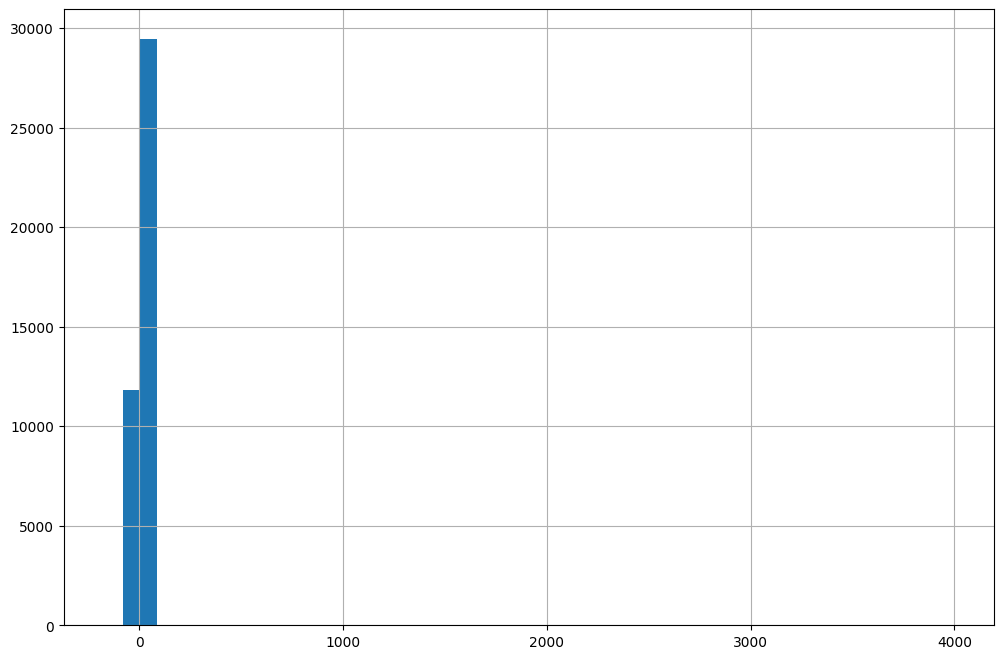

In [ ]:
diff_df.difference.hist(bins= 50, figsize=(12,8));
diff_df.difference.describe()

## 5.excluding the outlayers

In [ ]:
# calculate the quartiles
Q1 = diff_df["difference"].quantile(0.25)
Q3 = diff_df["difference"].quantile(0.75)

# calculate the interquartile range
IQR = Q3-Q1

# filter the DataFrame to include only "non-outliers"
diff_no_outliers_df = diff_df.loc[(diff_df["difference"] >= (Q1 - 1.5*IQR)) & (diff_df["difference"] <= (Q3 + 1.5*IQR))]
diff_no_outliers_df

,order_id,created_date,total_paid,state,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,105.98,6.99
...,...,...,...,...,...,...
41294,527042,2018-03-14 11:47:50,18.98,Completed,13.99,4.99
41295,527070,2018-03-14 11:50:48,24.97,Completed,19.98,4.99
41296,527074,2018-03-14 11:51:42,24.97,Completed,19.98,4.99
41297,527096,2018-03-14 11:58:40,34.96,Completed,29.97,4.99


In [ ]:
# Now we need to remove these orders with extreme differences from our orders_lines_merged DataFrame.
normal_diff_list = list(diff_no_outliers_df["order_id"].unique())
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_cl["order_id"].isin(normal_diff_list), :]
len(orders_qu["order_id"].unique()), len(orderlines_qu["order_id"].unique())

(40594, 40594)

In [ ]:
diff_df

,order_id,created_date,total_paid,state,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,105.98,6.99
...,...,...,...,...,...,...
41294,527042,2018-03-14 11:47:50,18.98,Completed,13.99,4.99
41295,527070,2018-03-14 11:50:48,24.97,Completed,19.98,4.99
41296,527074,2018-03-14 11:51:42,24.97,Completed,19.98,4.99
41297,527096,2018-03-14 11:58:40,34.96,Completed,29.97,4.99


# Analysis

## Answering the first questions from the LMS


### 1-How should products be classified into different categories to simplify reports and analysis?


computers_accessories    2717
Telephony_and_tablets    2133
electronics              1789
others                   1317
computers                1130
audio                     337
watches_gifts             206
accessories               179
Name: product_categories, dtype: int64

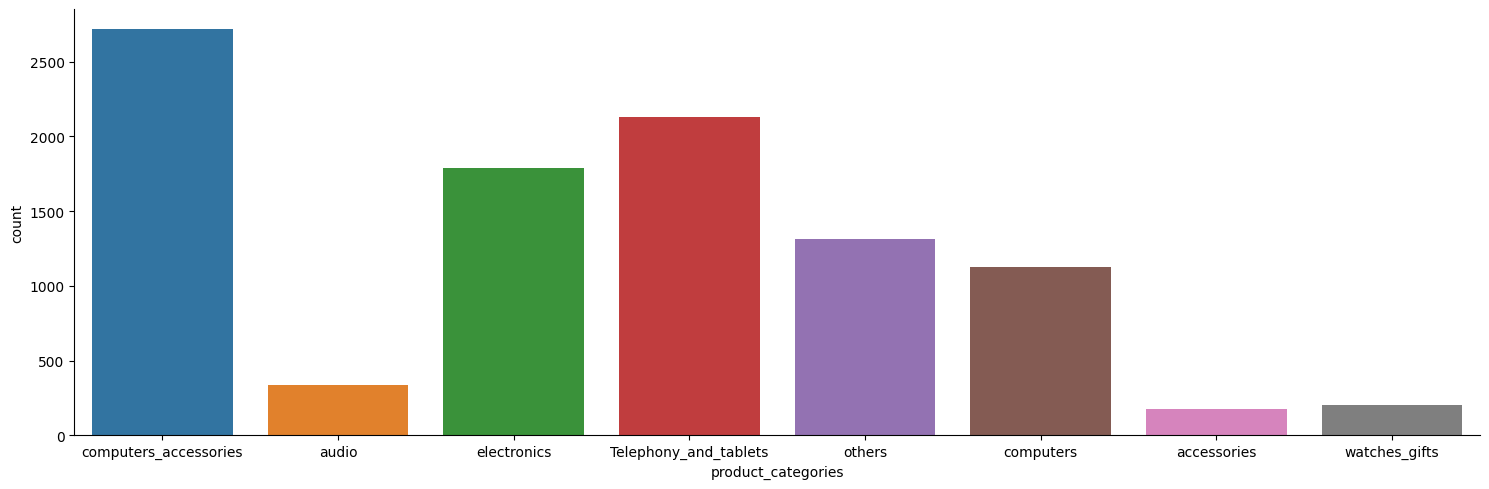

In [ ]:
products_cl2.product_categories.unique()
sns.catplot(products_cl2,
            x="product_categories",
            kind="count",
            aspect = 3);
products_cl2.product_categories.value_counts()

### 2-What is the distribution of product prices across different categories?




In [ ]:
# this is the distribution of products
sns.catplot(products_cl2,
            x="product_categories",
            y="price",
            kind="box",
            aspect=1.5,
            height=70)

In [ ]:
products_cl2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9808 entries, 0 to 19325
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sku                 9808 non-null   object 
 1   name                9808 non-null   object 
 2   desc                9808 non-null   object 
 3   price               9808 non-null   float64
 4   promo_price         9808 non-null   object 
 5   in_stock            9808 non-null   int64  
 6   type                9808 non-null   object 
 7   category            9808 non-null   object 
 8   product_categories  9808 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 766.2+ KB


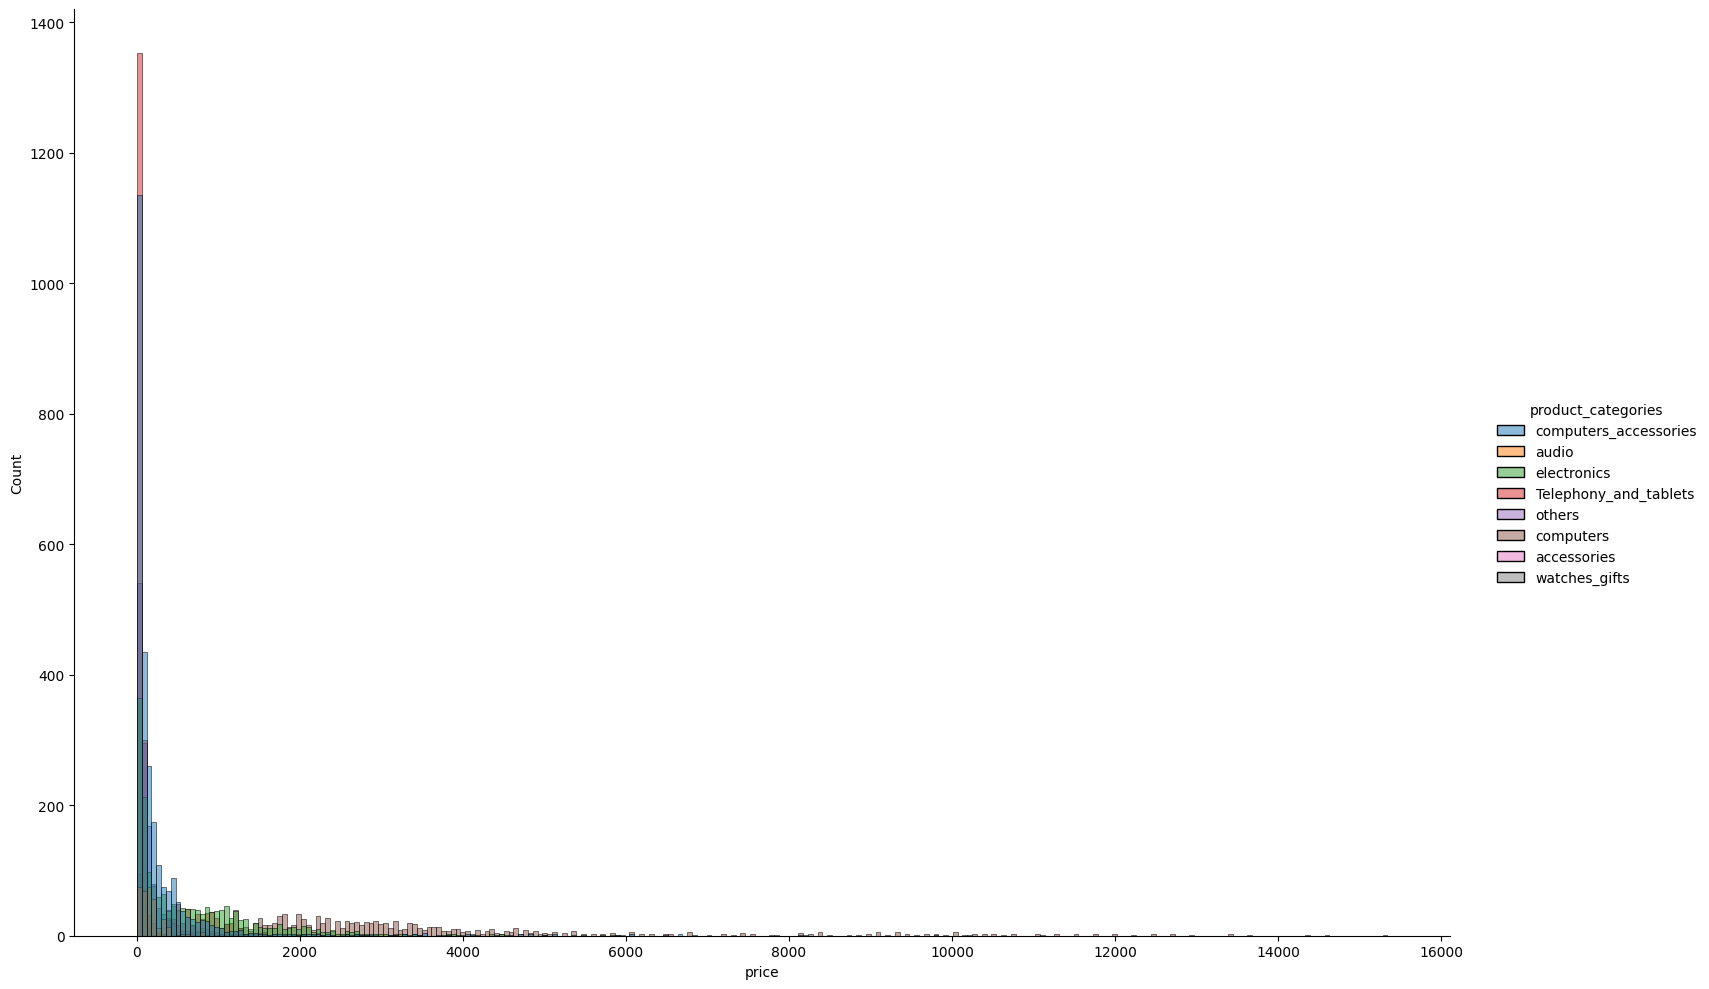

In [ ]:
sns.displot(products_cl2,
            x="price",
            hue="product_categories",
            aspect=1.5,
            height=10)

### 3-How many products are being discounted?

In [ ]:
ol_p = orderlines_qu.merge(products_cl2,
                    how="left",
                    left_on="sku",
                    right_on="sku")
ol_p["discount_amount"] = ol_p["price"] - ol_p["unit_price"]
ol_p.sort_values(by="discount_amount", ascending=False)
products_with_dicounts = ol_p.loc[ol_p["discount_amount"] > 0].sort_values(by="discount_amount", ascending=False)
products_without_dicounts = ol_p.loc[ol_p["discount_amount"] <= 0].sort_values(by="discount_amount", ascending=False)
products_with_dicounts
# products_without_dicounts

,id,order_id,product_id,product_quantity,sku,unit_price,date,name,desc,price,promo_price,in_stock,type,category,product_categories,discount_amount
17724,1303519,382526,0,1,PAC2067,479.00,2017-07-26 19:41:00,"Second hand - Apple iMac 24 ""Core 2 Duo 28 GHz...",Computer Refurbished iMac 24 inch Core 2 Duo 2...,1799.00,4.855.949,0,1282,Computers,computers,1320.00
13320,1265635,364414,0,1,PAC2071,489.00,2017-06-11 12:34:44,"Second hand - Apple iMac 24 ""Core 2 Duo 28 GHz...",Computer Refurbished iMac 24 inch Core 2 Duo 2...,1799.00,4.889.998,0,1282,Computers,computers,1310.00
11988,1251378,357485,0,1,PAC2065,499.00,2017-05-20 07:18:41,"Second hand - Apple iMac 24 ""Core 2 Duo 28 GHz...",Computer Refurbished iMac 24 inch Core 2 Duo 2...,1799.00,499,0,1282,Computers,computers,1300.00
28623,1407335,426708,0,1,PAC2281,255.59,2017-11-14 12:47:25,"Second hand - Apple iMac 20 ""Core 2 Duo 226GHz...",Refurbished iMac 20 inch Core 2 Duo | 2GB RAM ...,1499.00,2.555.945,0,"5,43E+15",Computers,computers,1243.41
25880,1385192,416025,0,1,PAC2062,335.59,2017-10-23 00:51:52,"Second hand - Apple iMac 20 ""Core 2 Duo 266GHz...",IMac used 20 inch Core 2 Duo 266GHz | 4GB RAM ...,1499.00,3.355.948,0,51882158,Computers,computers,1163.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,1144577,308802,0,1,BNQ0034,363.99,2017-01-13 13:59:46,"GW2765HT Monitor Benq 27 """,LED 27-inch monitor flicker-free technology an...,364.00,3.639.898,0,1296,Monitors,computers_accessories,0.01
2151,1140642,307125,0,1,BNQ0034,363.99,2017-01-11 10:44:41,"GW2765HT Monitor Benq 27 """,LED 27-inch monitor flicker-free technology an...,364.00,3.639.898,0,1296,Monitors,computers_accessories,0.01
15220,1284906,373806,0,1,SXA0007,209.99,2017-07-06 18:18:02,SecurityXtra One Security Support iPad Pro Adj...,Adjustable safety bracket anchored to the wall...,210.00,2.099.895,0,1216,Computer_Stands,computers_accessories,0.01
12060,1252345,357956,0,1,LAC0179,718.99,2017-05-22 13:07:28,12TB LaCie 2big Thunderbolt 2,Dual RAID disk box 12TB Thunderbolt 2 for Mac ...,719.00,6.539.941,0,11935397,Hard_drives,computers_accessories,0.01


### 4-How big are the offered discounts as a percentage of the product prices?

In [ ]:
products_with_dicounts["discount_percentage"] = (products_with_dicounts["discount_amount"]/products_with_dicounts["price"]) * 100
products_with_dicounts

,id,order_id,product_id,product_quantity,sku,unit_price,date,name,desc,price,promo_price,in_stock,type,category,product_categories,discount_amount,discount_percentage
17724,1303519,382526,0,1,PAC2067,479.00,2017-07-26 19:41:00,"Second hand - Apple iMac 24 ""Core 2 Duo 28 GHz...",Computer Refurbished iMac 24 inch Core 2 Duo 2...,1799.00,4.855.949,0,1282,Computers,computers,1320.00,73.37
13320,1265635,364414,0,1,PAC2071,489.00,2017-06-11 12:34:44,"Second hand - Apple iMac 24 ""Core 2 Duo 28 GHz...",Computer Refurbished iMac 24 inch Core 2 Duo 2...,1799.00,4.889.998,0,1282,Computers,computers,1310.00,72.82
11988,1251378,357485,0,1,PAC2065,499.00,2017-05-20 07:18:41,"Second hand - Apple iMac 24 ""Core 2 Duo 28 GHz...",Computer Refurbished iMac 24 inch Core 2 Duo 2...,1799.00,499,0,1282,Computers,computers,1300.00,72.26
28623,1407335,426708,0,1,PAC2281,255.59,2017-11-14 12:47:25,"Second hand - Apple iMac 20 ""Core 2 Duo 226GHz...",Refurbished iMac 20 inch Core 2 Duo | 2GB RAM ...,1499.00,2.555.945,0,"5,43E+15",Computers,computers,1243.41,82.95
25880,1385192,416025,0,1,PAC2062,335.59,2017-10-23 00:51:52,"Second hand - Apple iMac 20 ""Core 2 Duo 266GHz...",IMac used 20 inch Core 2 Duo 266GHz | 4GB RAM ...,1499.00,3.355.948,0,51882158,Computers,computers,1163.41,77.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,1144577,308802,0,1,BNQ0034,363.99,2017-01-13 13:59:46,"GW2765HT Monitor Benq 27 """,LED 27-inch monitor flicker-free technology an...,364.00,3.639.898,0,1296,Monitors,computers_accessories,0.01,0.00
2151,1140642,307125,0,1,BNQ0034,363.99,2017-01-11 10:44:41,"GW2765HT Monitor Benq 27 """,LED 27-inch monitor flicker-free technology an...,364.00,3.639.898,0,1296,Monitors,computers_accessories,0.01,0.00
15220,1284906,373806,0,1,SXA0007,209.99,2017-07-06 18:18:02,SecurityXtra One Security Support iPad Pro Adj...,Adjustable safety bracket anchored to the wall...,210.00,2.099.895,0,1216,Computer_Stands,computers_accessories,0.01,0.00
12060,1252345,357956,0,1,LAC0179,718.99,2017-05-22 13:07:28,12TB LaCie 2big Thunderbolt 2,Dual RAID disk box 12TB Thunderbolt 2 for Mac ...,719.00,6.539.941,0,11935397,Hard_drives,computers_accessories,0.01,0.00


### 5-How do seasonality and special dates (Christmas, Black Friday) affect sales?

,order_id
date,
2017-01-31,5996
2017-02-28,2552
2017-03-31,218
2017-04-30,1849
2017-05-31,2125
2017-06-30,1696
2017-07-31,4056
2017-08-31,2668
2017-09-30,2464


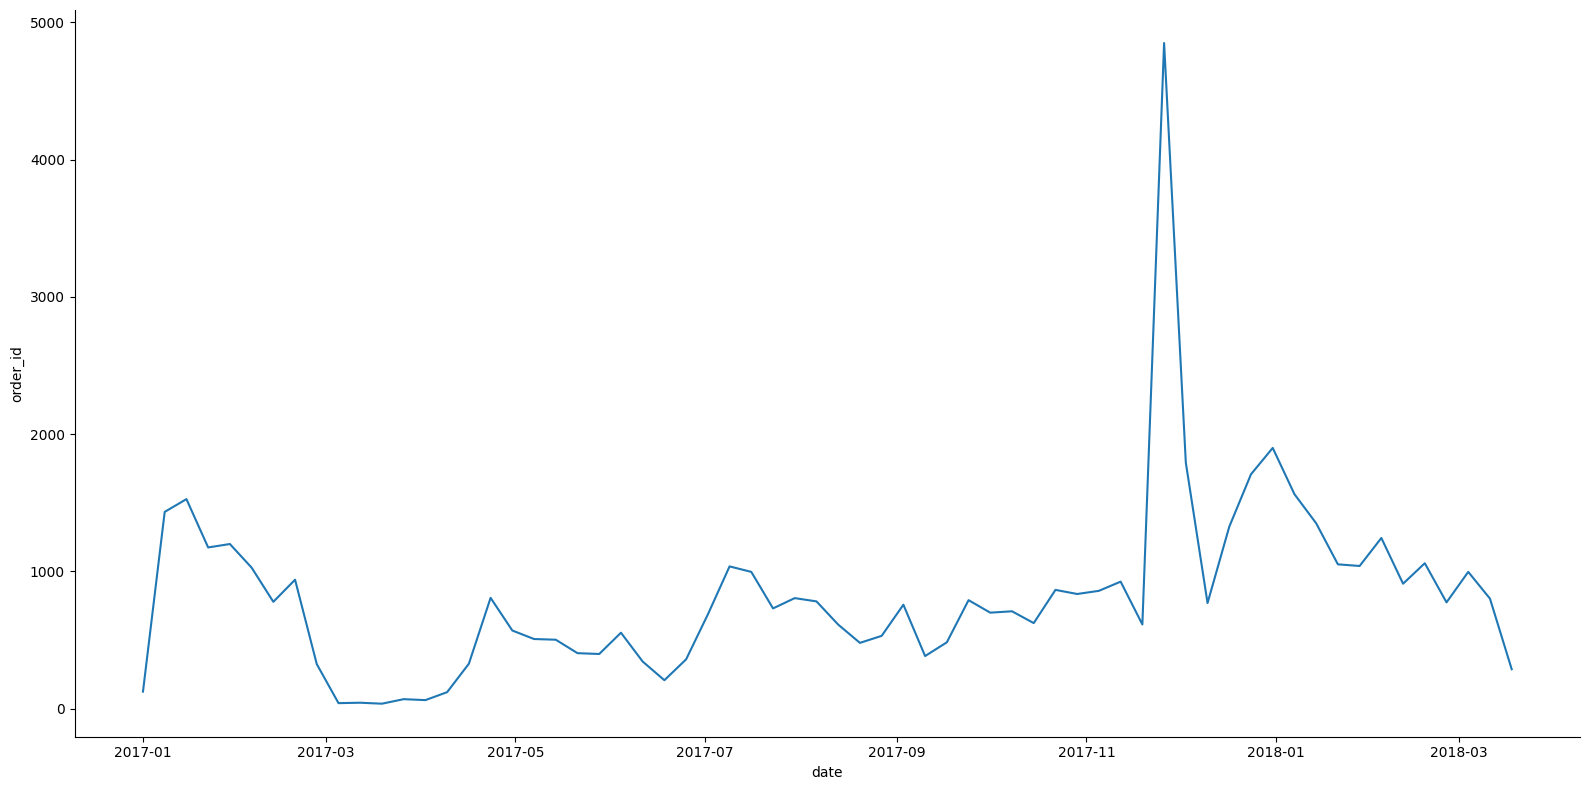

In [ ]:
ol_p.resample("M", on="date")["order_id"].count().to_frame()
sns.relplot(data = ol_p.resample("W", on="date")["order_id"].count().to_frame(),
            kind="line",
           x="date",
           y="order_id",
               height=8,
             aspect=2
            )
ol_p.resample("M", on="date")["order_id"].count().to_frame()

### 6-How could data collection be improved?

In [ ]:
# more careful to put in the data from all this things (duplicate, missing values, corupted data inside the columns, mixed data types)
# is it manualy entered or code releted


## Answering more question from the LMS

### 1-What is the time period that the dataset covers?

In [ ]:
orderlines_qu.sort_values(by="date", ascending=False).head(1)
orderlines_qu.sort_values(by="date", ascending=False).tail(1)
# 2017-01-01 ======= 2018-03-14

,id,order_id,product_id,product_quantity,sku,unit_price,date
7,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16


### 2-What is the overall revenue for that time?

In [ ]:
orders_qu.total_paid.sum()

7920477.509999999

### 3-Are there seasonal patterns in the evolution of sales?

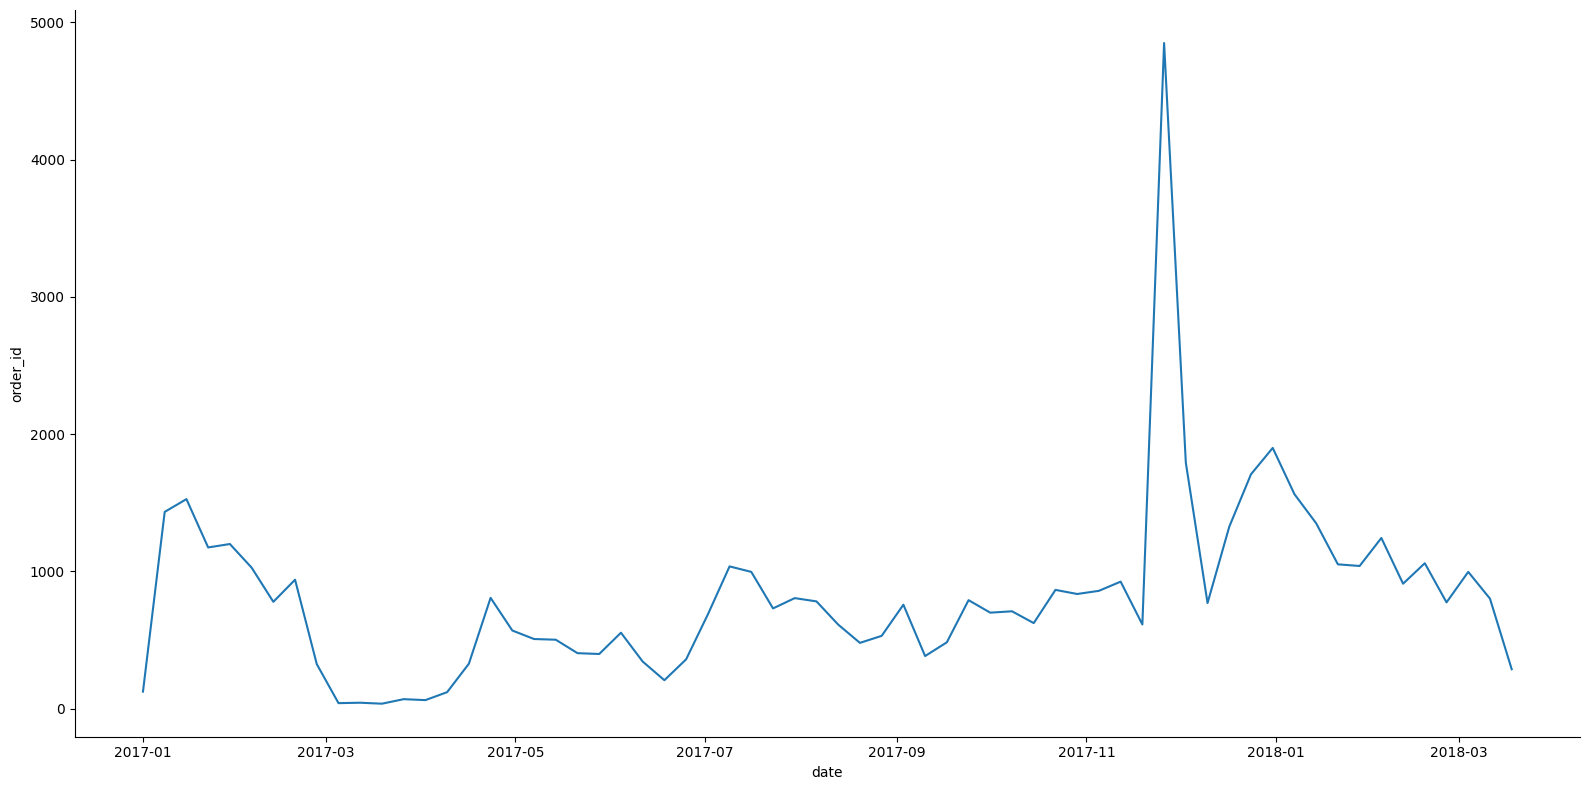

In [ ]:
sns.relplot(data = ol_p.resample("W", on="date")["order_id"].count().to_frame(),
            kind="line",
           x="date",
           y="order_id",
               height=8,
             aspect=2
            )
# ya ofcourse there is, black friday , cristmas, january and july

### 4-What are the most sold products?

In [ ]:
# the most sold is computers_accessories in term of product_categories
ol_p.groupby("product_categories").agg({"product_quantity":"sum"}).sort_values(by="product_quantity", ascending=False)

,product_quantity
product_categories,
computers_accessories,28169
Telephony_and_tablets,11320
electronics,9459
others,4494
audio,3408
accessories,1176
watches_gifts,934
computers,316


In [ ]:
# the most sold is APP1190 in term of SKU
ol_p.groupby(["sku", "name"]).agg({"product_quantity":"sum"}).sort_values(by="product_quantity", ascending=False)


,,product_quantity
sku,name,
APP1190,IPhone AppleCare Protection Plan,953
APP0698,Apple Lightning Cable Connector to USB 1m White (OEM),811
APP1922,AirPods Apple Bluetooth Headset for iPhone iPad iPod and Apple Watch,532
APP0927,EarPods Apple Headphones with Remote and Mic (OEM),488
WDT0183,"Red 4TB WD 35 ""Mac PC hard drive and NAS",476
...,...,...
GTE0017-A,Open - G-Tech G-DRIVE Hard Disk Thunderbolt and USB 3.0 3TB,1
PAR0073,Parrot AR Drone 2.0 Power Edition cuadricóptero,1
GTE0059-A,Open - G-Technology G-DRIVE Hard Disk Thunderbolt 8TB 7200rpm USB 3.0,1


### 5-What are the products that generate the most revenue?

In [ ]:
orders_qu.head()

,order_id,created_date,total_paid,state
1,241423,2017-11-06 13:10:02,136.15,Completed
2,242832,2017-12-31 17:40:03,15.76,Completed
3,243330,2017-02-16 10:59:38,84.98,Completed
5,245275,2017-06-28 11:35:37,149.00,Completed
6,245595,2017-01-21 12:52:47,112.97,Completed


In [ ]:
ol_p.head()

,id,order_id,product_id,product_quantity,sku,unit_price,date,name,desc,price,promo_price,in_stock,type,category,product_categories,discount_amount
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,60.99,499.899,1,12755395,Mount_kits,electronics,13.50
1,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,iOttie Easy View 2 Car Black Support,IPhone car holder 7 plus / 7/6 Plus / 6 / 5s /...,22.95,169.896,0,5720,Phone_stands,Telephony_and_tablets,3.96
2,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,Apple 85W MagSafe 2 charger MacBook Pro screen...,Apple MagSafe 2 Charger for MacBook Pro 15-inc...,89.00,649.903,1,13005399,Charger,electronics,16.81
3,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14,(Open) Crucial 240GB SSD 7mm BX200,SSD hard drive and high-speed performance with...,76.99,707.001,0,1298,na,others,16.09
4,1119145,299561,0,1,PEB0015,142.49,2017-01-01 02:38:50,Pebble Smartwatch Time Steel Black,Bluetooth Smart Watch with steel case leather ...,299.99,1.229.905,0,11905404,na,others,157.50


In [ ]:
diff_df.head()

,order_id,created_date,total_paid,state,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,105.98,6.99


In [ ]:
# LGE0044 is the most product that generate revenue
ol_p["unit_price_total"] = ol_p["unit_price"] * ol_p["product_quantity"]
ol_p.groupby(["sku", "name"]).agg({"unit_price_total":"sum"}).sort_values(by="unit_price_total", ascending=False)

,,unit_price_total
sku,name,
LGE0044,"LG 27UD88-W Monitor 27 ""UHD 4K USB 3.0 USB-C",135375.83
APP2446,Apple iPhone 6 32GB Space Gray,104560.64
APP1922,AirPods Apple Bluetooth Headset for iPhone iPad iPod and Apple Watch,85653.26
APP2477,Apple iPhone 64GB Space Gray 8,85301.93
APP1970,Apple iPhone 32GB Space Gray,80715.76
...,...,...
BOO0066,Booq Boa Skin XS iPad Case Purple / Gray,4.29
KIN0125,Kingston 8GB Micro SDHC Class 10 45MB / s,3.99
PUR0107,Puro Just Cavalli Swan iPhone Case Passion / 5s / 5 black,3.99


In [ ]:
# computers_accessories is the most category that generate revenue
ol_p.groupby(["product_categories"]).agg({"unit_price_total":"sum"}).sort_values(by="unit_price_total", ascending=False)

,unit_price_total
product_categories,
computers_accessories,3106308.44
Telephony_and_tablets,2155314.71
electronics,1206578.59
audio,399824.79
others,399320.62
computers,238113.10
watches_gifts,212214.30
accessories,42940.94


## extra analysis

In [ ]:
# avg blackfriday sales = 20-25 november 2017
products_with_dicounts_in_blackfriday = products_with_dicounts.loc[(products_with_dicounts["date"].between("2017-11-20", "2017-11-27")) & (products_with_dicounts["product_categories"]== "computers_accessories")]
products_with_dicounts_in_blackfriday.discount_percentage.median()

23.8553289726818

In [ ]:
# cristmas sales = 24-30 december 2017
products_with_dicounts_in_cristmas = products_with_dicounts.loc[(products_with_dicounts["date"].between("2017-12-24", "2017-12-30")) & (products_with_dicounts["product_categories"]== "computers_accessories")]
products_with_dicounts_in_cristmas.discount_percentage.median()

19.059512531220392

In [ ]:
# avg sales outside blackfriday and cristmas
products_with_discounts_not_in_BF_or_CS = products_with_dicounts.loc[~(((products_with_dicounts["date"].between("2017-11-20", "2017-11-27"))\
                                                                        &\
                                                                        products_with_dicounts["date"].between("2017-12-24", "2017-12-30"))\
                                                                        & \
                                                                         ((products_with_dicounts["product_categories"]== "computers_accessories")))]
products_with_discounts_not_in_BF_or_CS.discount_percentage.median()

19.49761578067899

#Answering the big question (WHETHER OR NOT ITS BENEFICIAL TO DISCOUNT PRODUCTS)

In [ ]:
#discount status
ol_p["discount_status"] = ol_p["discount_amount"].apply(lambda x: "yes" if x > 0 else "no")
# finding the discount_precentage
ol_p["discount_percentage"] = (ol_p["discount_amount"] / ol_p["price"])*100
ol_p.sort_values(by="discount_percentage", ascending=False).tail(50)
# i considered that the discounts that are more than 50% are aggresive discounts
ol_p["discount_type"] = ol_p["discount_percentage"]\
.apply(lambda x:\
       "no_discount" if x <= 0\
       else "Low" if x < 10\
       else "Medium" if pd.Series.between(x, 10, 20)\
       else "High") # we used here the (pd.series.between(x,20,49)) because without it we cant use between inside lambda


## Sales with discounts and without discounts

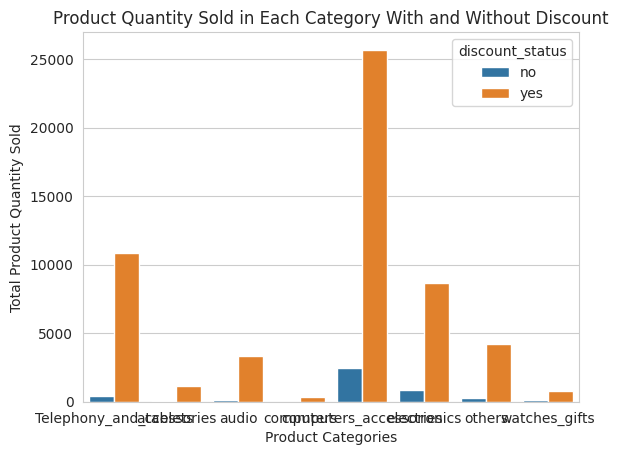

,product_categories,discount_status,product_quantity
0,Telephony_and_tablets,no,439
1,Telephony_and_tablets,yes,10881
2,accessories,no,11
3,accessories,yes,1165
4,audio,no,107
5,audio,yes,3301
6,computers,no,1
7,computers,yes,315
8,computers_accessories,no,2470
9,computers_accessories,yes,25699


In [ ]:
# the difference between sales with discounts and without discounts
ol_p_grouped = ol_p.groupby(["product_categories", "discount_status"])["product_quantity"].sum().reset_index()
sns.barplot(x="product_categories",
            y="product_quantity",
            hue="discount_status",
            data=ol_p_grouped)
plt.xlabel("Product Categories")
plt.ylabel("Total Product Quantity Sold")
plt.title("Product Quantity Sold in Each Category With and Without Discount")
plt.show()
ol_p_grouped

In [ ]:
# revenue of products without sales
((ol_p.loc[ol_p["discount_status"] == "no"]["unit_price"]) *  (ol_p.loc[ol_p["discount_status"] == "no"]["product_quantity"])).sum()

563300.99

In [ ]:
# revenue of products with sales
print(((ol_p.loc[ol_p["discount_status"] == "yes"]["unit_price"]) *  (ol_p.loc[ol_p["discount_status"] == "yes"]["product_quantity"])).sum())
# revenue of the same products if there is no sales on them
print(((ol_p.loc[ol_p["discount_status"] == "yes"]["price"]) *  (ol_p.loc[ol_p["discount_status"] == "yes"]["product_quantity"])).sum())

7197314.499999999
8739337.399999999


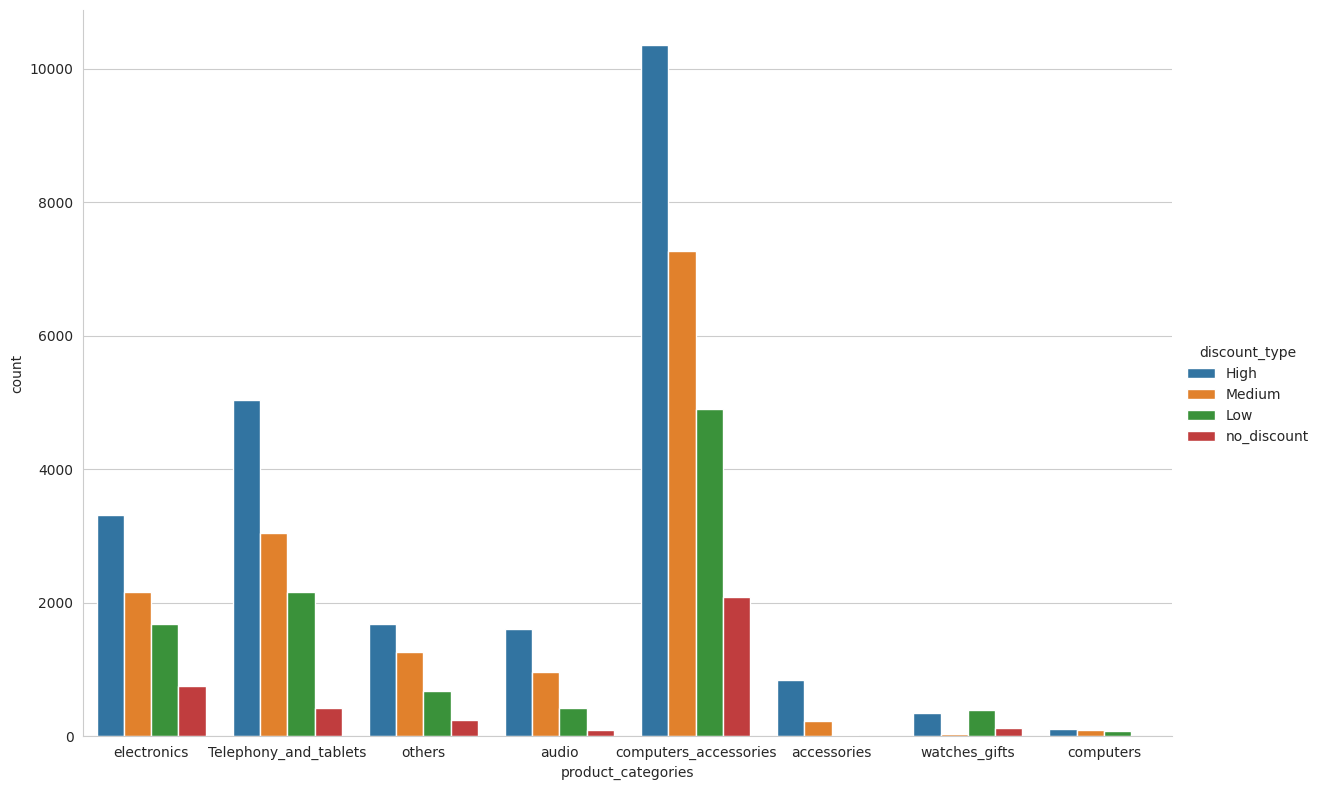

In [ ]:
sns.catplot(kind="count",
            data=ol_p,
            x="product_categories",
            hue="discount_type",
            height=8,
            aspect=1.5);

In [ ]:
ol_p.head(1)

,id,order_id,product_id,product_quantity,sku,unit_price,date,name,desc,price,...,in_stock,type,category,product_categories,discount_amount,unit_price_total,discount_status,discount_percentage,discount_type,revenue_per_sale
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,60.99,...,1,12755395,Mount_kits,electronics,13.50,47.49,yes,22.13,High,47.49


## Average Revenue per Order vs. Discount Rate & Number of Orders vs. Discount Rate

<ipython-input-78-74243536a669>:13: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




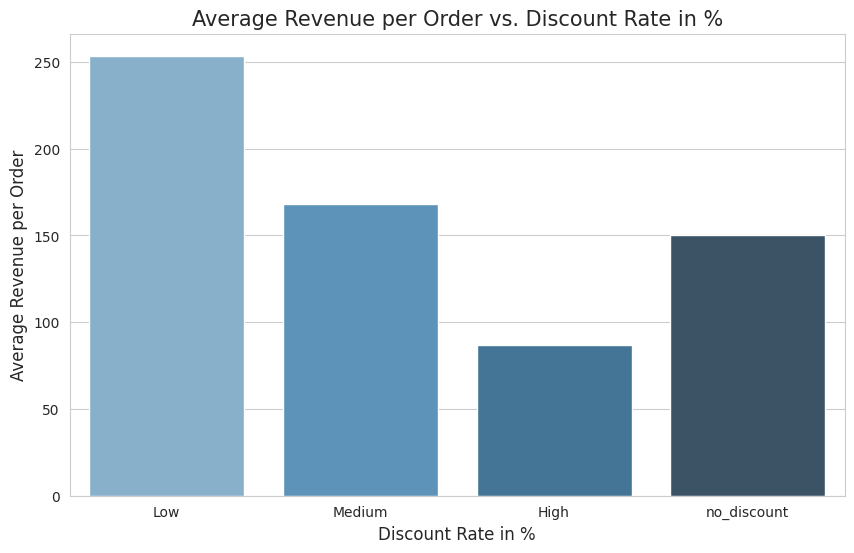

<ipython-input-78-74243536a669>:21: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




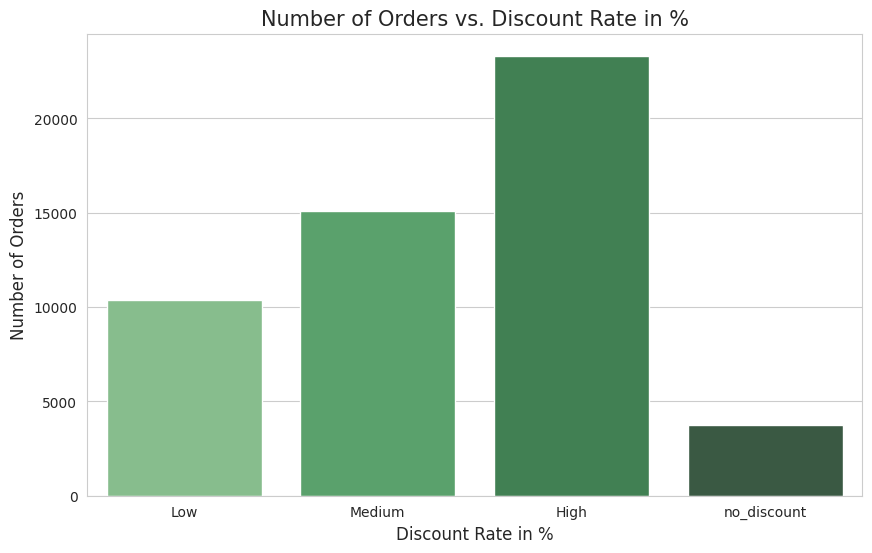

In [ ]:
sns.set_style("whitegrid")

# 'Average Revenue' and 'Number of Orders' per 'Discount Type'
average_revenue = ol_p.groupby('discount_type')['unit_price_total'].mean()
num_orders = ol_p.groupby('discount_type')['order_id'].count()

average_revenue_df = average_revenue.reset_index().rename(columns={'unit_price_total': 'average_revenue'})
num_orders_df = num_orders.reset_index().rename(columns={'order_id': 'num_orders'})

order = ["Low", "Medium", "High", "no_discount"]

plt.figure(figsize=(10, 6))
sns.barplot(x='discount_type', y='average_revenue', data=average_revenue_df, palette='Blues_d', ci=None, order=order)
plt.title('Average Revenue per Order vs. Discount Rate in %', fontsize=15)
plt.xlabel('Discount Rate in %', fontsize=12)
plt.ylabel('Average Revenue per Order', fontsize=12)
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(x='discount_type', y='num_orders', data=num_orders_df, palette='Greens_d', ci=None, order=order)
plt.title('Number of Orders vs. Discount Rate in %', fontsize=15)
plt.xlabel('Discount Rate in %', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.show()

## Extra Analysis

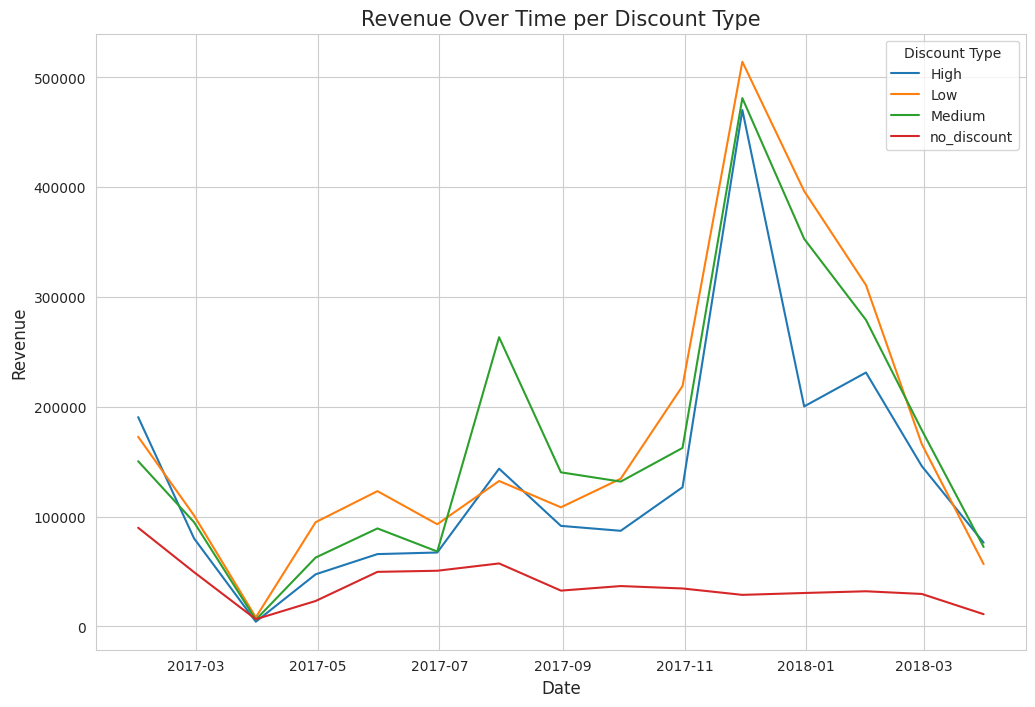

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ol_p['date'] = pd.to_datetime(ol_p['date'])

revenue_per_discount_type = ol_p.groupby([pd.Grouper(key='date', freq='M'), 'discount_type'])['unit_price_total'].sum().reset_index().rename(columns={'discount_type': 'Discount Type'})

plt.figure(figsize=(12, 8))
sns.lineplot(data=revenue_per_discount_type, x='date', y='unit_price_total', hue='Discount Type')
plt.title('Revenue Over Time per Discount Type', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.show()


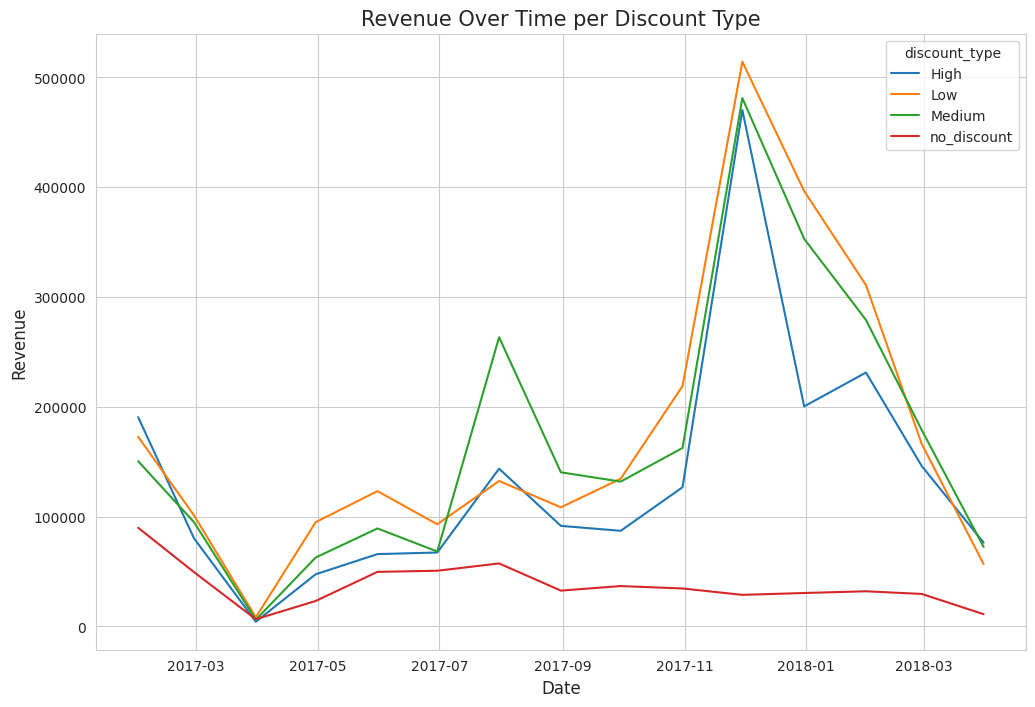

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ol_p['date'] = pd.to_datetime(ol_p['date'])


revenue_per_discount_type = ol_p.groupby([pd.Grouper(key='date', freq='M'), 'discount_type'])['unit_price_total'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(data=revenue_per_discount_type, x='date', y='unit_price_total', hue='discount_type')
plt.title('Revenue Over Time per Discount Type', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.show()

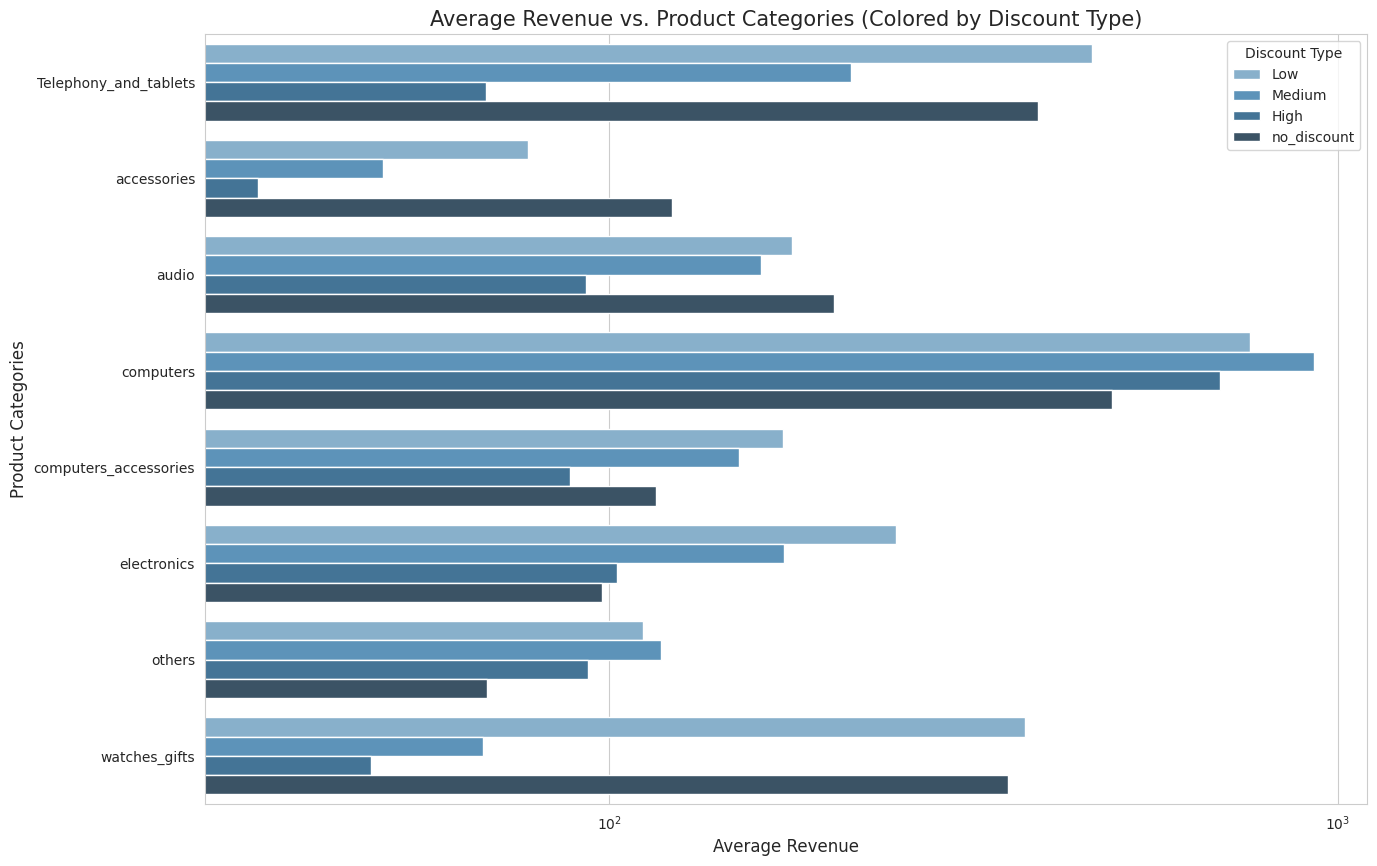

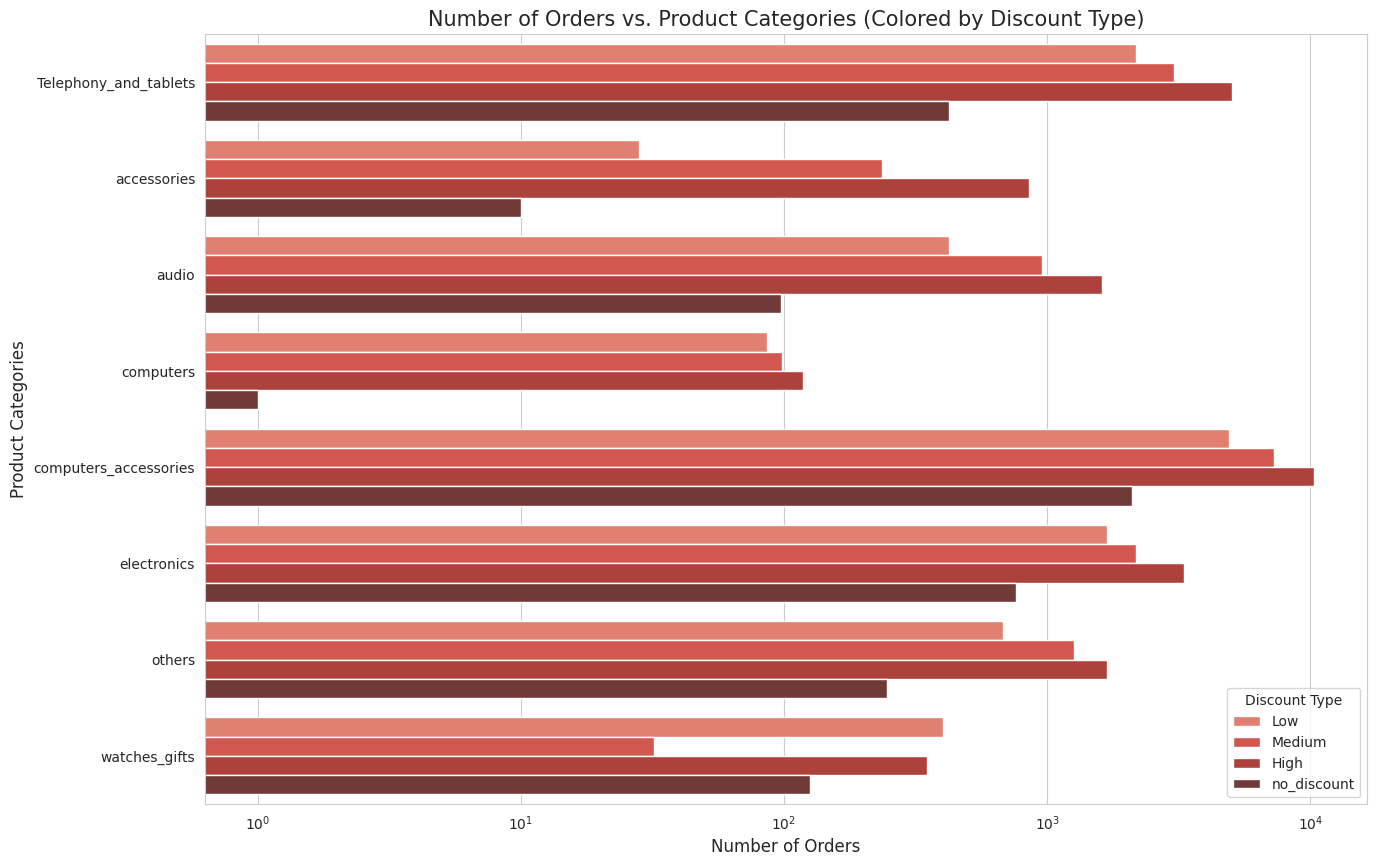

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set style of the seaborn plot
sns.set_style("whitegrid")

# Define the desired order
order = ["Low", "Medium", "High", "no_discount"]

# Convert the 'discount_type' to a categorical type with the desired order
ol_p['discount_type'] = pd.Categorical(ol_p['discount_type'], categories=order, ordered=True)

# Calculate 'Average Revenue' and 'Number of Orders' per 'Product Category' and 'Discount Type'
average_revenue = ol_p.groupby(['product_categories', 'discount_type'])['unit_price_total'].mean().reset_index()
average_revenue = average_revenue.rename(columns={'unit_price_total': 'average_revenue'})

num_orders = ol_p.groupby(['product_categories', 'discount_type'])['order_id'].count().reset_index()
num_orders = num_orders.rename(columns={'order_id': 'num_orders'})

# Create the figure for the first plot
plt.figure(figsize=(15, 10))
chart = sns.barplot(x='average_revenue', y='product_categories', hue='discount_type', data=average_revenue, palette='Blues_d', errorbar=None)
plt.title('Average Revenue vs. Product Categories (Colored by Discount Type)', fontsize=15)
plt.xlabel('Average Revenue', fontsize=12)
plt.ylabel('Product Categories', fontsize=12)
chart.set_xscale('log')
plt.legend(title='Discount Type')
plt.show()

# Create the figure for the second plot
plt.figure(figsize=(15, 10))
chart = sns.barplot(x='num_orders', y='product_categories', hue='discount_type', data=num_orders, palette='Reds_d', errorbar=None)
plt.title('Number of Orders vs. Product Categories (Colored by Discount Type)', fontsize=15)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Product Categories', fontsize=12)
chart.set_xscale('log')
plt.legend(title='Discount Type')
plt.show()


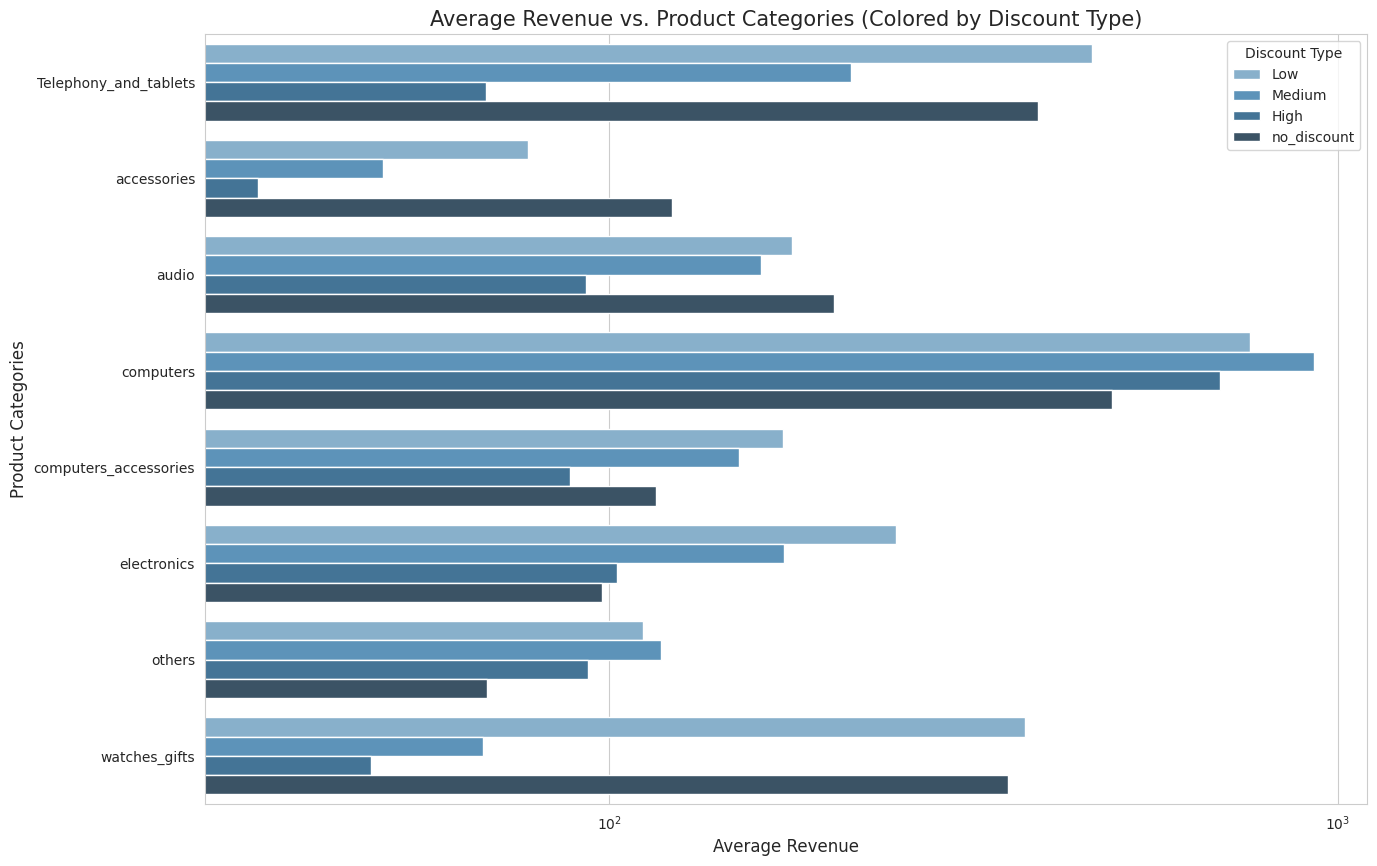

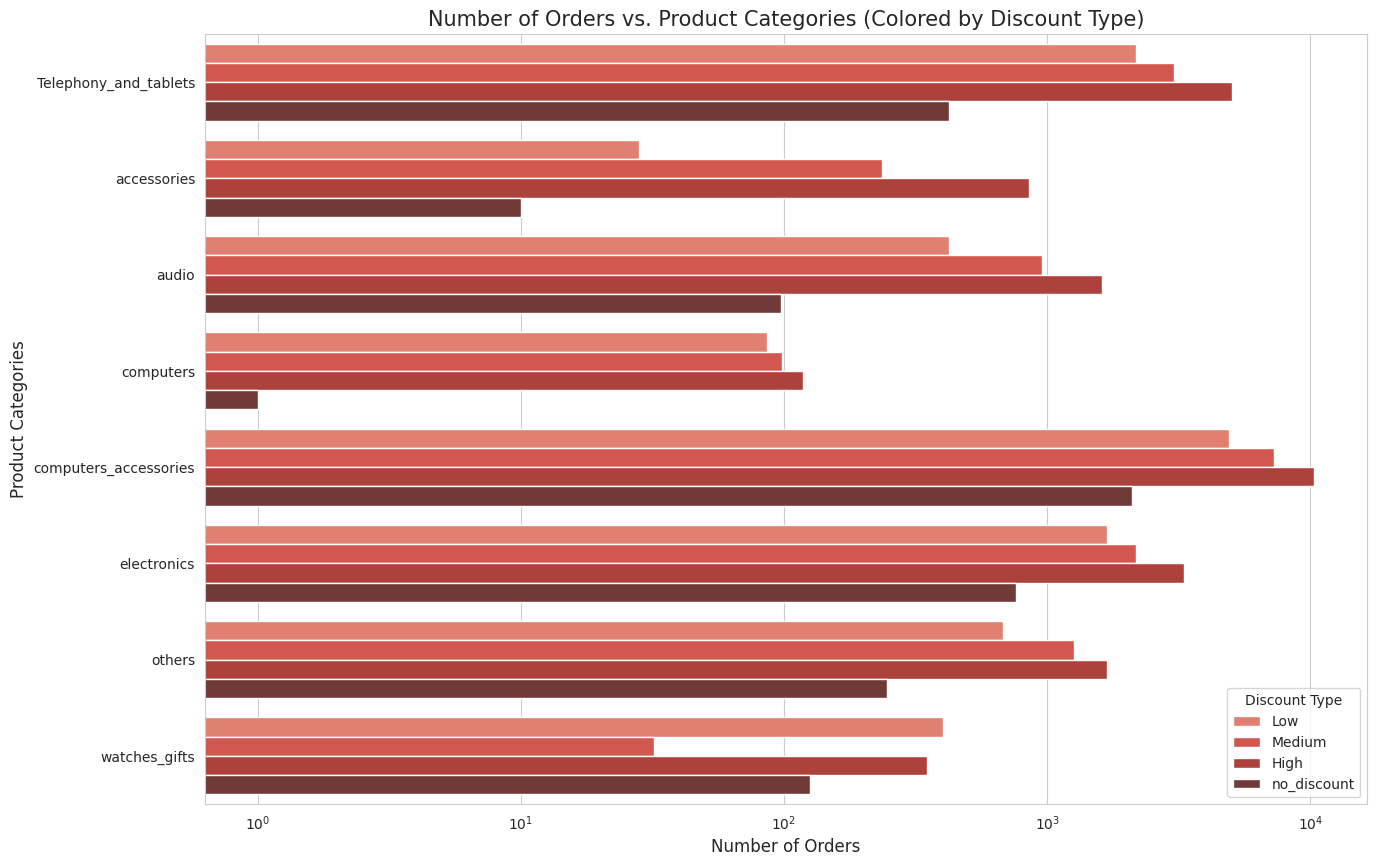

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set style of the seaborn plot
sns.set_style("whitegrid")

# Calculate 'Average Revenue' and 'Number of Orders' per 'Product Category' and 'Discount Type'
average_revenue = ol_p.groupby(['product_categories', 'discount_type'])['unit_price_total'].mean().reset_index()
average_revenue = average_revenue.rename(columns={'unit_price_total': 'average_revenue'})

num_orders = ol_p.groupby(['product_categories', 'discount_type'])['order_id'].count().reset_index()
num_orders = num_orders.rename(columns={'order_id': 'num_orders'})

# Create the figure for the first plot
plt.figure(figsize=(15, 10))
chart = sns.barplot(x='average_revenue', y='product_categories', hue='discount_type', data=average_revenue, palette='Blues_d', errorbar=None)
plt.title('Average Revenue vs. Product Categories (Colored by Discount Type)', fontsize=15)
plt.xlabel('Average Revenue', fontsize=12)
plt.ylabel('Product Categories', fontsize=12)
chart.set_xscale('log')
plt.legend(title='Discount Type')
plt.show()

# Create the figure for the second plot
plt.figure(figsize=(15, 10))
chart = sns.barplot(x='num_orders', y='product_categories', hue='discount_type', data=num_orders, palette='Reds_d', errorbar=None)
plt.title('Number of Orders vs. Product Categories (Colored by Discount Type)', fontsize=15)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Product Categories', fontsize=12)
chart.set_xscale('log')
plt.legend(title='Discount Type')
plt.show()
